Importation des librairies et Chargement des Données

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Configuration aléatoire pour la reproductibilité
np.random.seed(42)

def lire_alpha_digit(indices=None):
    """
    Fonction pour lire la base Binary AlphaDigits.
    Charge le fichier 'binaryalphadigs.mat' qui doit être présent dans le dossier.
    Arguments:
        indices: liste des indices des caractères à charger (0-9: chiffres, 10-35: lettres A-Z)
    Retourne:
        X: matrice des données (n_samples, n_pixels)
   
    """
    try:
        mat = scipy.io.loadmat('binaryalphadigs.mat')
        data = mat['dat']
        
        X = []
        num_classes, num_samples = data.shape
        
        if indices is None:
            indices = range(num_classes)
            
        for i in indices:
            for j in range(num_samples):
                X.append(data[i, j].flatten())
                
        return np.array(X)
    except FileNotFoundError:
        print("Erreur : Le fichier 'binaryalphadigs.mat' est introuvable.")
        return None

def load_mnist_binarized():
    """
    Charge et binarise la base MNIST.
    Retourne X_train, y_train, X_test, y_test.
   
    """
    print("Chargement de MNIST...")
    # Utilisation de scikit-learn pour récupérer MNIST (alternative au lien direct)
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    
    X = mnist.data
    y = mnist.target.astype(int)
    
    # Normalisation et Binarisation (seuil à 0.5 après normalisation)
    X = X / 255.0
    X = (X > 0.5).astype(float)
    
    # One-hot encoding des labels
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y.reshape(-1, 1))
    
    # Séparation train/test (60000 train, 10000 test standard)
    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=10000, random_state=42)
    
    return X_train, y_train, X_test, y_test

# Fonctions d'activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    # Astuce numérique pour la stabilité (soustraire le max)
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

Implémentation du RBM (Restricted Boltzmann Machine)

In [2]:
class RBM:
    """Structure représentant un RBM avec champs W, a, b [cite: 32]"""
    def __init__(self, W, a, b):
        self.W = W # Poids
        self.a = a # Biais visible
        self.b = b # Biais caché

def init_RBM(p, q):
    """
    Initialise les poids et biais d'un RBM.
    p: dimension d'entrée (visible)
    q: dimension cachée
    Poids ~ N(0, 0.01), biais à 0.
    [cite: 40, 41, 42]
    """
    W = np.random.normal(0, 0.01, (p, q))
    a = np.zeros(p)
    b = np.zeros(q)
    return RBM(W, a, b)

def entree_sortie_RBM(rbm, X):
    """Calcule P(h=1|v) via sigmoïde [cite: 43]"""
    return sigmoid(X @ rbm.W + rbm.b)

def sortie_entree_RBM(rbm, H):
    """Calcule P(v=1|h) via sigmoïde [cite: 44]"""
    return sigmoid(H @ rbm.W.T + rbm.a)

def train_RBM(rbm, X, epochs, lr, batch_size):
    """
    Apprentissage non supervisé par Contrastive-Divergence-1.
    [cite: 45, 46]
    """
    n_samples, p = X.shape
    q = rbm.W.shape[1]
    
    for epoch in range(epochs):
        np.random.shuffle(X)
        total_error = 0
        
        for i in range(0, n_samples, batch_size):
            batch = X[i:min(i + batch_size, n_samples)]
            actual_batch_size = batch.shape[0]
            
            # 1. Gibbs Sampling (CD-1)
            # Positive phase
            v0 = batch
            p_h0 = entree_sortie_RBM(rbm, v0)
            h0 = (np.random.rand(actual_batch_size, q) < p_h0).astype(float)
            
            # Negative phase
            p_v1 = sortie_entree_RBM(rbm, h0)
            v1 = (np.random.rand(actual_batch_size, p) < p_v1).astype(float)
            p_h1 = entree_sortie_RBM(rbm, v1)
            
            # 2. Mise à jour des gradients
            grad_W = (v0.T @ p_h0 - v1.T @ p_h1) / actual_batch_size
            grad_a = np.mean(v0 - v1, axis=0)
            grad_b = np.mean(p_h0 - p_h1, axis=0)
            
            rbm.W += lr * grad_W
            rbm.a += lr * grad_a
            rbm.b += lr * grad_b
            
            # Calcul erreur quadratique de reconstruction [cite: 46]
            total_error += np.mean((v0 - v1)**2)
            
        if epoch % 10 == 0:
            print(f"RBM Epoch {epoch}/{epochs} - Reconstruction Error: {total_error / (n_samples / batch_size):.4f}")
            
    return rbm

def generer_image_RBM(rbm, n_iter_gibbs, n_images):
    """Génère des images via l'échantillonneur de Gibbs [cite: 47, 48]"""
    p = rbm.W.shape[0]
    q = rbm.W.shape[1]
    
    # Initialisation aléatoire
    v = (np.random.rand(n_images, p) < 0.5).astype(float)
    
    for _ in range(n_iter_gibbs):
        h_prob = entree_sortie_RBM(rbm, v)
        h = (np.random.rand(n_images, q) < h_prob).astype(float)
        
        v_prob = sortie_entree_RBM(rbm, h)
        v = (np.random.rand(n_images, p) < v_prob).astype(float)
        
    # Affichage
    plt.figure(figsize=(10, 2))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        # On suppose des images carrées pour l'affichage (ex: 20x16 pour AlphaDigits ou 28x28 pour MNIST)
        dim = int(np.sqrt(p))
        if p == 784: dim = 28 # MNIST
        elif p == 320: dim_y, dim_x = 20, 16 # AlphaDigit
        else: dim_y, dim_x = dim, dim
        
        if p == 320:
             plt.imshow(v[i].reshape(dim_y, dim_x), cmap='gray')
        else:
             plt.imshow(v[i].reshape(dim, dim), cmap='gray')
        plt.axis('off')
    plt.title(f"Génération RBM (iter={n_iter_gibbs})")
    plt.show()
    return v

Implémentation du DBN (Deep Belief Network)

In [3]:
# === CELLULE 3-BIS : Étude Préliminaire (Binary AlphaDigits) ===
# Cette étape valide que vos RBM/DBN génèrent bien des caractères (Section 4 du PDF)

# 1. Charger des données spécifiques (ex: index 10 = 'A', index 11 = 'B')
# On concatène les données de A et B pour voir si le réseau apprend les deux
data_alpha = lire_alpha_digit([10, 11]) # Indices pour A et B

if data_alpha is not None:
    n_data, input_dim = data_alpha.shape
    print(f"Données chargées: {n_data} images de dimension {input_dim}")

    # --- Test RBM sur AlphaDigits ---
    print("\n--- Apprentissage RBM (AlphaDigits) ---")
    # On configure un RBM avec p entrées et q neurones cachés (ex: 100)
    rbm_alpha = init_RBM(p=input_dim, q=100)
    
    # Entrainement (augmenter epochs si l'image générée est bruitée)
    rbm_alpha = train_RBM(rbm_alpha, data_alpha, epochs=100, lr=0.1, batch_size=10)
    
    # Génération
    print("Génération via RBM :")
    generer_image_RBM(rbm_alpha, n_iter_gibbs=100, n_images=5)

    # --- Test DBN sur AlphaDigits ---
    print("\n--- Apprentissage DBN (AlphaDigits) ---")
    # On configure un DBN [320, 200, 100]
    dbn_alpha = init_DBN([input_dim, 200, 100])
    
    # Entrainement
    dbn_alpha = train_DBN(dbn_alpha, data_alpha, epochs=100, lr=0.1, batch_size=10)
    
    # Génération
    print("Génération via DBN :")
    generer_image_DBN(dbn_alpha, n_iter_gibbs=100, n_images=5)
else:
    print("Impossible de lancer l'étude préliminaire : fichier .mat manquant.")

Erreur : Le fichier 'binaryalphadigs.mat' est introuvable.
Impossible de lancer l'étude préliminaire : fichier .mat manquant.


In [4]:
class DBN:
    """Liste de RBMs [cite: 33]"""
    def __init__(self, rbms):
        self.rbms = rbms

def init_DBN(layer_sizes):
    """
    Construit et initialise un DBN.
    layer_sizes: liste des tailles [input, hidden1, hidden2, ...]
    Utilise itérativement init_RBM. [cite: 54, 55]
    """
    rbms = []
    for i in range(len(layer_sizes) - 1):
        rbm = init_RBM(layer_sizes[i], layer_sizes[i+1])
        rbms.append(rbm)
    return DBN(rbms)

def train_DBN(dbn, X, epochs, lr, batch_size):
    """
    Apprentissage Greedy Layer-Wise. [cite: 56, 57]
    Entraine chaque RBM successivement. [cite: 58]
    """
    input_data = X
    
    for i, rbm in enumerate(dbn.rbms):
        print(f"--- Entrainement Couche DBN {i+1} ---")
        # Entrainement du RBM courant
        dbn.rbms[i] = train_RBM(rbm, input_data, epochs, lr, batch_size)
        
        # Calcul de la sortie pour la couche suivante (moyenne activée)
        input_data = entree_sortie_RBM(dbn.rbms[i], input_data)
        
    return dbn

def generer_image_DBN(dbn, n_iter_gibbs, n_images):
    """
    Génère des échantillons suivant un DBN. [cite: 60, 61]
    Stratégie: Générer sur le dernier RBM, puis redescendre.
    """
    # 1. Échantillonnage de Gibbs sur le dernier RBM (niveau le plus profond)
    last_rbm = dbn.rbms[-1]
    p_last = last_rbm.W.shape[0] # Entrée du dernier RBM
    q_last = last_rbm.W.shape[1] # Caché du dernier RBM
    
    # Init aléatoire au niveau top
    h = (np.random.rand(n_images, q_last) < 0.5).astype(float)
    
    # Gibbs sur le dernier niveau
    for _ in range(n_iter_gibbs):
        v_prob = sortie_entree_RBM(last_rbm, h)
        v = (np.random.rand(n_images, p_last) < v_prob).astype(float)
        h_prob = entree_sortie_RBM(last_rbm, v)
        h = (np.random.rand(n_images, q_last) < h_prob).astype(float)
        
    # Le 'v' obtenu est l'entrée de la dernière couche. Il faut redescendre le réseau.
    current_input = v
    
    # 2. Propagation descendante (Top-Down)
    for i in range(len(dbn.rbms) - 1, -1, -1):
        rbm = dbn.rbms[i]
        # On utilise sortie_entree_RBM pour passer de la couche cachée vers visible
        probs = sortie_entree_RBM(rbm, current_input)
        # Binarisation (sauf peut-être pour la couche visible finale si on veut du niveau de gris)
        current_input = (np.random.rand(n_images, rbm.W.shape[0]) < probs).astype(float)
        
    # Affichage
    v_final = current_input
    p = v_final.shape[1]
    plt.figure(figsize=(10, 2))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        dim = int(np.sqrt(p))
        if p == 784: dim = 28
        elif p == 320: dim_y, dim_x = 20, 16
        else: dim_y, dim_x = dim, dim
        
        if p == 320:
             plt.imshow(v_final[i].reshape(dim_y, dim_x), cmap='gray')
        else:
             plt.imshow(v_final[i].reshape(dim, dim), cmap='gray')
        plt.axis('off')
    plt.title(f"Génération DBN (iter={n_iter_gibbs})")
    plt.show()
    return v_final

Implémentation du DNN (Deep Neural Network)

In [5]:
class DNN:
    """DNN = DBN + Couche de classification [cite: 66]"""
    def __init__(self, dbn, classification_layer=None):
        self.dbn = dbn
        # Classification layer: Poids et biais pour Softmax
        self.W_class = classification_layer['W'] if classification_layer else None
        self.b_class = classification_layer['b'] if classification_layer else None

def init_DNN(layer_sizes):
    """
    layer_sizes: [input, hidden1, ..., hiddenN, output_classes]
    Retourne un DNN initialisé. [cite: 65, 66]
    """
    # La partie DBN concerne tout sauf la dernière couche (classification)
    dbn_sizes = layer_sizes[:-1]
    dbn = init_DBN(dbn_sizes)
    
    # Initialisation couche classification
    input_dim = layer_sizes[-2]
    output_dim = layer_sizes[-1]
    W_class = np.random.normal(0, 0.01, (input_dim, output_dim))
    b_class = np.zeros(output_dim)
    
    return DNN(dbn, {'W': W_class, 'b': b_class})

def pretrain_DNN(dnn, X, epochs, lr, batch_size):
    """Pré-entrainement des couches cachées via train_DBN [cite: 67, 68]"""
    dnn.dbn = train_DBN(dnn.dbn, X, epochs, lr, batch_size)
    return dnn

def calcul_softmax(X, dnn):
    """Calcule probabilités sortie via softmax [cite: 69]"""
    Z = X @ dnn.W_class + dnn.b_class
    return softmax(Z)

def entree_sortie_reseau(dnn, X):
    """
    Passe avant (Forward pass).
    Retourne une liste contenant les sorties de chaque couche.
    [cite: 71, 72]
    """
    activations = [X]
    current_input = X
    
    # Passage dans le DBN (sigmoïdes)
    for rbm in dnn.dbn.rbms:
        current_input = entree_sortie_RBM(rbm, current_input)
        activations.append(current_input)
        
    # Passage dans la couche de classification (Softmax)
    probs = calcul_softmax(current_input, dnn)
    activations.append(probs)
    
    return activations

def retropropagation(dnn, X, y, epochs, lr, batch_size):
    """
    Apprentissage supervisé (Fine-tuning). [cite: 73, 74]
    """
    n_samples = X.shape[0]
    
    for epoch in range(epochs):
        # Mélange des données
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_loss = 0
        
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            batch_len = X_batch.shape[0]
            
            # 1. Forward Pass
            activations = entree_sortie_reseau(dnn, X_batch)
            y_pred = activations[-1] # Sortie Softmax
            
            # 2. Calcul de l'erreur (Entropie croisée) [cite: 74]
            # Loss = -sum(y_true * log(y_pred))
            loss = -np.sum(y_batch * np.log(y_pred + 1e-9)) / batch_len
            epoch_loss += loss
            
            # 3. Backward Pass
            
            # Delta couche sortie (Softmax + CrossEntropy derivative = pred - true)
            delta = (y_pred - y_batch) / batch_len
            
            # Gradient pour la couche de classification
            grad_W_class = activations[-2].T @ delta
            grad_b_class = np.sum(delta, axis=0)
            
            # Rétropropagation à travers le DBN
            # W_new = W_old - lr * grad
            # Note: On doit stocker les gradients avant de mettre à jour pour l'étape précédente
            
            prev_W_class = dnn.W_class.copy() # Sauvegarde pour calcul delta couche précédente
            
            # Mise à jour couche classification
            dnn.W_class -= lr * grad_W_class
            dnn.b_class -= lr * grad_b_class
            
            # Propagation vers les couches cachées
            # delta_hidden = (delta @ W_next.T) * sigmoid'(a)
            # sigmoid'(x) = x * (1 - x) pour x étant la sortie de la sigmoïde
            
            delta_curr = delta
            W_next = prev_W_class
            
            # On itère à l'envers sur les RBMs
            for j in range(len(dnn.dbn.rbms) - 1, -1, -1):
                rbm = dnn.dbn.rbms[j]
                output_j = activations[j+1] # Sortie de la couche actuelle
                input_j = activations[j]    # Entrée de la couche actuelle
                
                # Dérivée sigmoïde
                sig_deriv = output_j * (1 - output_j)
                
                # Calcul delta
                delta_prev = (delta_curr @ W_next.T) * sig_deriv
                
                # Gradients
                grad_W = input_j.T @ delta_prev
                grad_b = np.sum(delta_prev, axis=0) # biais caché 'b' du RBM
                # Note: Le biais 'a' du RBM n'est pas utilisé en feedforward standard DNN (sauf si on considère l'entrée)
                
                # Mise à jour
                W_next = rbm.W.copy() # Pour la couche d'avant
                rbm.W -= lr * grad_W
                rbm.b -= lr * grad_b
                
                delta_curr = delta_prev

        if epoch % 10 == 0:
            print(f"Retroprop Epoch {epoch}/{epochs} - Cross Entropy Loss: {epoch_loss:.4f}")
            
    return dnn

def test_DNN(dnn, X_test, y_test):
    """
    Test du réseau et calcul du taux d'erreur.
    [cite: 75, 77, 78]
    """
    activations = entree_sortie_reseau(dnn, X_test)
    y_pred_proba = activations[-1]
    
    # Conversion One-hot -> Classe
    pred_labels = np.argmax(y_pred_proba, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    
    error_rate = np.mean(pred_labels != true_labels)
    return error_rate

Script Principal pour Analyse Compararative (MNIST)

In [6]:
# Paramètres globaux [cite: 95]
INPUT_DIM = 784 # MNIST
OUTPUT_DIM = 10
LR_RBM = 0.1
LR_DNN = 0.1
BATCH_SIZE = 128
EPOCHS_RBM = 10 # Réduit pour tester rapidement (mettre 100+ pour rendu final)
EPOCHS_DNN = 20 # Réduit pour tester rapidement (mettre 200 pour rendu final)

# Chargement données
X_train_full, y_train_full, X_test, y_test = load_mnist_binarized()

def run_comparison_experiment(hidden_layers_cfg, train_size):
    """
    Exécute la comparaison Pre-trained vs Random Init.
    Retourne (erreur_pretrained, erreur_random)
    """
    # Sous-échantillonnage des données train selon train_size [cite: 113]
    indices = np.random.choice(X_train_full.shape[0], train_size, replace=False)
    X_train = X_train_full[indices]
    y_train = y_train_full[indices]
    
    config = [INPUT_DIM] + hidden_layers_cfg + [OUTPUT_DIM]
    print(f"\n--- Config: {config}, Data: {train_size} ---")
    
    # 1. Réseau avec Pré-entrainement [cite: 105, 106]
    print("Training DNN WITH Pre-training...")
    dnn_pre = init_DNN(config)
    dnn_pre = pretrain_DNN(dnn_pre, X_train, epochs=EPOCHS_RBM, lr=LR_RBM, batch_size=BATCH_SIZE)
    dnn_pre = retropropagation(dnn_pre, X_train, y_train, epochs=EPOCHS_DNN, lr=LR_DNN, batch_size=BATCH_SIZE)
    err_pre = test_DNN(dnn_pre, X_test, y_test)
    
    # 2. Réseau Initialisation Aléatoire [cite: 107]
    print("Training DNN WITHOUT Pre-training...")
    dnn_rand = init_DNN(config)
    dnn_rand = retropropagation(dnn_rand, X_train, y_train, epochs=EPOCHS_DNN, lr=LR_DNN, batch_size=BATCH_SIZE)
    err_rand = test_DNN(dnn_rand, X_test, y_test)
    
    print(f"Error Pre-trained: {err_pre:.4f} | Error Random: {err_rand:.4f}")
    return err_pre, err_rand

# --- Exécution des Analyses (Figures) ---

# Figure 1: Variation du nombre de couches [cite: 111]
# Fixe: 200 neurones/couche, 10000 data. Variable: nb couches.
nb_layers_list = [2, 3, 4] # Exemple: 2 couches cachées, puis 3...
res_fig1 = []
print("\n=== Figure 1: Analysis by Depth ===")
for l in nb_layers_list:
    cfg = [200] * l # l couches de 200
    res_fig1.append(run_comparison_experiment(cfg, 5000)) # 5000 données pour rapidité

# Figure 2: Variation du nombre de neurones [cite: 112]
# Fixe: 2 couches, 10000 data. Variable: nb neurones.
neurons_list = [100, 300, 500]
res_fig2 = []
print("\n=== Figure 2: Analysis by Width ===")
for n in neurons_list:
    cfg = [n, n] # 2 couches de n
    res_fig2.append(run_comparison_experiment(cfg, 5000))

# Figure 3: Variation du nombre de données [cite: 113]
# Fixe: 2 couches de 200. Variable: data size.
data_sizes = [1000, 3000, 7000]
res_fig3 = []
print("\n=== Figure 3: Analysis by Data Size ===")
for sz in data_sizes:
    cfg = [200, 200]
    res_fig3.append(run_comparison_experiment(cfg, sz))

Chargement de MNIST...

=== Figure 1: Analysis by Depth ===

--- Config: [784, 200, 200, 10], Data: 5000 ---
Training DNN WITH Pre-training...
--- Entrainement Couche DBN 1 ---
RBM Epoch 0/10 - Reconstruction Error: 0.2006
--- Entrainement Couche DBN 2 ---
RBM Epoch 0/10 - Reconstruction Error: 0.3588
Retroprop Epoch 0/20 - Cross Entropy Loss: 92.3892
Retroprop Epoch 10/20 - Cross Entropy Loss: 92.0780
Training DNN WITHOUT Pre-training...
Retroprop Epoch 0/20 - Cross Entropy Loss: 92.5658
Retroprop Epoch 10/20 - Cross Entropy Loss: 92.5713
Error Pre-trained: 0.8443 | Error Random: 0.9094

--- Config: [784, 200, 200, 200, 10], Data: 5000 ---
Training DNN WITH Pre-training...
--- Entrainement Couche DBN 1 ---
RBM Epoch 0/10 - Reconstruction Error: 0.2033
--- Entrainement Couche DBN 2 ---
RBM Epoch 0/10 - Reconstruction Error: 0.3564
--- Entrainement Couche DBN 3 ---
RBM Epoch 0/10 - Reconstruction Error: 0.2999
Retroprop Epoch 0/20 - Cross Entropy Loss: 92.3309
Retroprop Epoch 10/20 - Cr

Affichage des Résultats

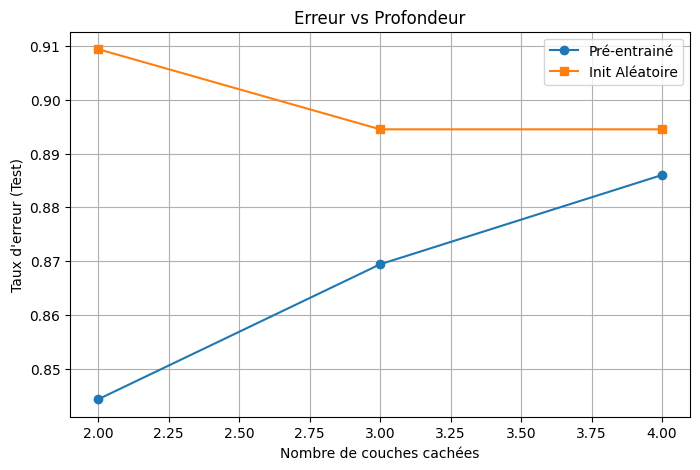

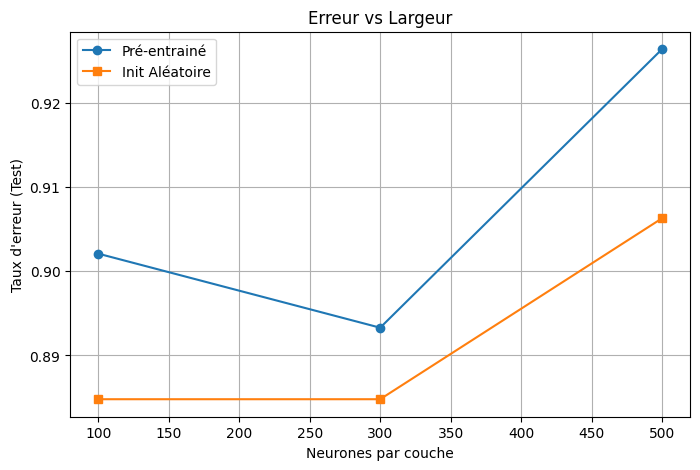

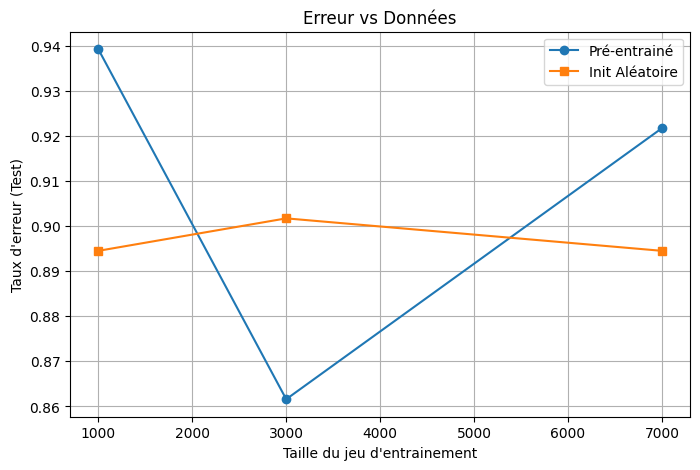

In [7]:
# Fonction utilitaire de plot
def plot_results(x_values, results, x_label, title):
    pre = [r[0] for r in results]
    rand = [r[1] for r in results]
    
    plt.figure(figsize=(8, 5))
    plt.plot(x_values, pre, 'o-', label='Pré-entrainé')
    plt.plot(x_values, rand, 's-', label='Init Aléatoire')
    plt.xlabel(x_label)
    plt.ylabel("Taux d'erreur (Test)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Affichage Fig 1
plot_results(nb_layers_list, res_fig1, "Nombre de couches cachées", "Erreur vs Profondeur")

# Affichage Fig 2
plot_results(neurons_list, res_fig2, "Neurones par couche", "Erreur vs Largeur")

# Affichage Fig 3
plot_results(data_sizes, res_fig3, "Taille du jeu d'entrainement", "Erreur vs Données")